### 1. VERIFY Dataset Exploration

This notebook provides a basic walkthrough of loading and exploring the VERIFY dataset. We'll look at its structure, some basic statistics, and examples of the data.

#### 1.1 Setup and Imports
First, let's import the necessary libraries. We'll use `datasets` from Hugging Face to load the data (if available on the Hub), `pandas` for data manipulation, `matplotlib` and `seaborn` for plotting.

In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
import sqlite3
import json
from collections import Counter
from huggingface_hub import hf_hub_download

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

#### 1.2 Loading the Dataset

The VERIFY dataset can be loaded either from the Hugging Face Hub or Kaggle or from GitHub or a local SQLite database file.

In [7]:
HF_DATASET_NAME = "sedislab/VERIFY"

# Option B: Local files (if cloned from GitHub: sedislab/verify)
# Adjust these paths if your local repository structure is different.
LOCAL_CSV_PATH = "data/verify.csv"
LOCAL_PARQUET_PATH = "data/verify.parquet"

# Option C: Local SQLite Database
# Replace with the actual path to your database if using this method.
DB_PATH = '/projects/path/to/verify-dataset/dataset.db' # Example path

df = None

In [8]:
# Option A: Loading from Hugging Face Hub
downloaded_file_path = None

downloaded_file_path = hf_hub_download(repo_id=HF_DATASET_NAME, filename="dataset.parquet", repo_type="dataset")
print(f"Successfully downloaded 'dataset.parquet' to: {downloaded_file_path}")

df = pd.read_parquet(downloaded_file_path)
print(f"Successfully read Parquet file with {len(df)} entries.")

if df is not None and not df.empty:
    print(f"Successfully loaded data from Hugging Face Hub ({len(df)} entries).")
else:
    print(f"All attempts to load from Hugging Face Hub ({HF_DATASET_NAME}) failed to populate DataFrame.")

Attempting to download and read dataset from Hugging Face Hub: sedislab/VERIFY...
Attempting to download 'dataset.parquet'...


dataset.parquet:   0%|          | 0.00/121M [00:00<?, ?B/s]

Successfully downloaded 'dataset.parquet' to: /root/.cache/huggingface/hub/datasets--sedislab--VERIFY/snapshots/2cf3dc431922f22901fbca9199fc56ec20c0ba43/dataset.parquet
Successfully read Parquet file with 217916 entries.
Successfully loaded data from Hugging Face Hub (217916 entries).


In [ ]:
# Option B: Loading from local Parquet or CSV
LOCAL_PARQUET_PATH = ""
LOCAL_CSV_PATH = ""

if os.path.exists(LOCAL_PARQUET_PATH):
    print(f"Loading data from local Parquet file: {LOCAL_PARQUET_PATH}")
    try:
        df = pd.read_parquet(LOCAL_PARQUET_PATH)
        print(f"Successfully loaded {len(df)} entries from local Parquet file.")
    except Exception as e:
        print(f"Error loading from local Parquet file: {e}")
elif os.path.exists(LOCAL_CSV_PATH):
    print(f"Loading data from local CSV file: {LOCAL_CSV_PATH}")
    try:
        df = pd.read_csv(LOCAL_CSV_PATH)
        print(f"Successfully loaded {len(df)} entries from local CSV file.")
    except Exception as e:
        print(f"Error loading from local CSV file: {e}")
else:
    print(f"Local Parquet/CSV files not found at expected paths: {LOCAL_PARQUET_PATH} or {LOCAL_CSV_PATH}")

In [ ]:
# Option C: Loading from SQLite
DB_PATH = ""

if os.path.exists(DB_PATH):
    print(f"Loading data from SQLite database: {DB_PATH}")
    try:
        conn = sqlite3.connect(DB_PATH)

        query = """
        SELECT
            f.id AS formula_id,
            f.formula AS ltl_formula_original,
            f.spot_formulas,
            f.canonical_form AS ltl_canonical_spot,
            f.depth AS ltl_depth,
            i.id AS itl_id,
            i.itl_text,
            i.canonical_form AS itl_is_canonical_rule_based,
            n.id AS nl_id,
            n.domain,
            n.activity,
            n.translation AS nl_translation
        FROM
            formulas f
        LEFT JOIN -- Use LEFT JOIN in case some ITLs or NLs are missing for a formula
            itl_representations i ON f.id = i.formula_id AND i.canonical_form = 1 -- Only canonical ITL
        LEFT JOIN
            nl_translations n ON f.id = n.formula_id AND i.id = n.itl_id -- Join on ITL ID too if NL is specific to ITL variant
        WHERE i.id IS NOT NULL AND n.id IS NOT NULL; -- Ensure we only get complete triplets
        """
        df = pd.read_sql_query(query, conn)
        conn.close()
        print(f"Successfully loaded {len(df)} entries from SQLite database.")
    except Exception as e:
        print(f"Error loading from SQLite: {e}")
else:
    print(f"SQLite database not found at {DB_PATH}.")

#### 1.3 Basic Dataset Information

Let's look at the first few rows, the shape of the dataset, and column information.

In [11]:
print("Dataset Head:")
print(df.head())

print("\nDataset Shape:")
print(df.shape)

print("\nDataset Columns:")
print(df.columns)

print("\nDataset Info:")
df.info()

Dataset Head:
   formula_id  ... generation_time
0      343478  ...       49.841681
1      148091  ...       44.507109
2      673588  ...       41.226336
3      557237  ...       34.440244
4      262955  ...       35.379813

[5 rows x 15 columns]

Dataset Shape:
(217916, 15)

Dataset Columns:
Index(['formula_id', 'formula', 'latex', 'formula_canonical_form', 'depth',
       'itl_id', 'itl_text', 'generation_method', 'verified', 'is_correct',
       'translation_id', 'domain', 'activity', 'translation',
       'generation_time'],
      dtype='object')

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217916 entries, 0 to 217915
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   formula_id              217916 non-null  int64  
 1   formula                 217916 non-null  object 
 2   latex                   217916 non-null  object 
 3   formula_canonical_form  217916 non-null  o

#### 1.4 Data Distributions
Let's visualize some key distributions.

##### **Distribution of Domains**

<ipython-input-12-15198a79c48a>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y='domain', order=df['domain'].value_counts().index, palette='viridis')


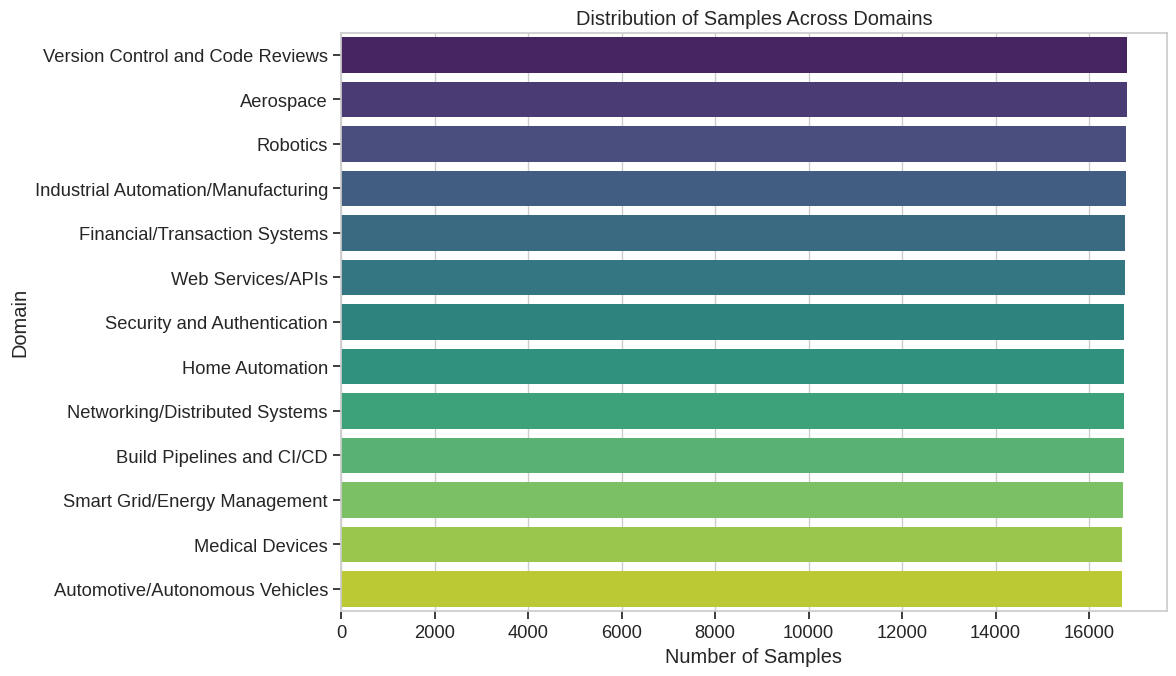

In [12]:
if not df.empty and 'domain' in df.columns:
    plt.figure(figsize=(12, 7))
    sns.countplot(data=df, y='domain', order=df['domain'].value_counts().index, palette='viridis')
    plt.title('Distribution of Samples Across Domains')
    plt.xlabel('Number of Samples')
    plt.ylabel('Domain')
    plt.tight_layout()
    plt.show()
else:
    print("Cannot plot domain distribution: DataFrame is empty or 'domain' column is missing.")

##### **Distribution of Natural Language (NL) Translation Lengths**
We can look at the word count of the NL translations.

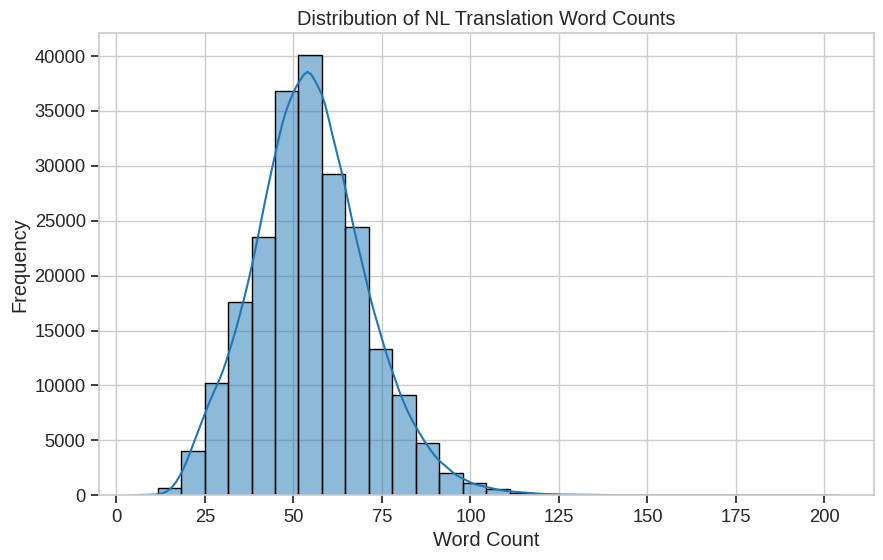


Statistics for NL Translation Word Counts:
count    217916.000000
mean         54.933786
std          16.098319
min           5.000000
25%          44.000000
50%          54.000000
75%          65.000000
max         204.000000
Name: nl_word_count, dtype: float64


In [14]:
if not df.empty and 'translation' in df.columns:
    df['nl_word_count'] = df['translation'].astype(str).apply(lambda x: len(x.split()))
    plt.figure(figsize=(10, 6))
    sns.histplot(df['nl_word_count'], kde=True, bins=30)
    plt.title('Distribution of NL Translation Word Counts')
    plt.xlabel('Word Count')
    plt.ylabel('Frequency')
    plt.show()

    print("\nStatistics for NL Translation Word Counts:")
    print(df['nl_word_count'].describe())
else:
    print("Cannot plot NL translation lengths: DataFrame is empty or 'translation' column is missing.")

#### 1.5 Example Triplets
Let's look at a few full examples of LTL-ITL-NL triplets.

In [16]:
if not df.empty:
    print("\n--- Example Triplets from the Dataset ---")
    num_examples_to_show = 3
    sample_size = min(num_examples_to_show, len(df))
    if sample_size > 0:
        for i, (_, row) in enumerate(df.sample(n=sample_size, random_state=42).iterrows()):
            print(f"\nExample #{i+1}:")
            print(f"  Domain: {row.get('domain', 'N/A')}")
            # Prefer spot_formulas if available, fallback to ltl_formula_original
            ltl_display = row.get('spot_formulas', row.get('formula', 'N/A'))
            print(f"  LTL (Spot/Original): {ltl_display}")
            print(f"  ITL: {row.get('itl_text', 'N/A')}")
            print(f"  Activity Context: {row.get('activity', 'N/A')}")
            print(f"  NL Translation: {row.get('translation', 'N/A')}")
            print("-" * 40)
    else:
        print("No data available to show examples.")
else:
    print("DataFrame is empty. Cannot show examples.")


--- Example Triplets from the Dataset ---

Example #1:
  Domain: Security and Authentication
  LTL (Spot/Original): F {\neg {F {v W F {u} R F {v W w}} W \left(t \land q\right)}}
  ITL: Eventually, not Eventually, v weakly until Eventually, u releases Eventually, v weakly until w weakly until q and t
  Activity Context: - v: Valid credentials are presented  
- u: User access is revoked  
- w: Security warning is issued  
- t: Temporary account lock is activated  
- q: Account quarantine is initiated
  NL Translation: Eventually, either the system permanently stops accepting valid credentials before any revocation occurs (with prior valid authentications always eventually triggering warnings followed by temporary lock and quarantine), or this warning-to-quarantine sequence must persistently follow all future valid authentications indefinitely.
----------------------------------------

Example #2:
  Domain: Aerospace
  LTL (Spot/Original): u \land F {s} R u R \left(t W u \lor v\right) W 

In [ ]:
print("Data exploration notebook finished.")